# Importar bibliotecas

In [1]:
import time
import matplotlib.pyplot as plt
from numpy import exp, log10 as log
import random
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec
import sympy as sp



# Funciones

In [2]:
# Definimos constantes por defecto para facilitar cambios futuros
DEFAULT_ESTRELLAS = 10_000_000
DEFAULT_TIEMPO_GYR = 10.0  # En Gigayears
DEFAULT_TIEMPO_YEARS = DEFAULT_TIEMPO_GYR * 10**9

def obtener_numero_estrellas(default=DEFAULT_ESTRELLAS):
    """
    Solicita al usuario el número de estrellas para la simulación.
    Maneja la entrada vacía y errores de conversión.
    """
    entrada = input(f"Ingrese el número de estrellas que intentará generar (deje en blanco para {default:,}): ")

    if not entrada:
        print(f"Iteraciones fijadas a {default:,}")
        return default

    try:
        iteraciones = int(entrada)
        print("Iteraciones fijadas a", iteraciones)
        return iteraciones
    except ValueError:
        print(f"No puede convertirse a entero, iteraciones fijadas a {default:,}")
        return default

def obtener_edad_maxima(default_years=DEFAULT_TIEMPO_YEARS):
    """
    Solicita la edad máxima en Gyr y la convierte a años.
    Maneja la entrada vacía y errores de conversión.
    """
    entrada = input("Ingrese edad máxima de las estrellas, en Gyr (deje en blanco para 10 Gyr): ")

    if not entrada:
        print("Edad máxima fijada a 10 Gyr")
        return default_years

    try:
        tiempo_gyr = float(entrada)
        tiempo_years = tiempo_gyr * 10**9
        print(f"Edad máxima fijada a {tiempo_gyr} Gyr")
        return tiempo_years
    except ValueError:
        print("No puede convertirse a flotante, Edad máxima fijada a 10 Gyr")
        return default_years




In [3]:
# IMF
def kroupa01(m):
	return np.where(m<0.5, 0.08**(-0.3) * (m/0.08)**-1.8, np.where(m<1.00, 0.08**-0.3 * (0.5/0.08)**-1.8 * (m/0.5)**-2.7,0.08**-0.3 * (0.5/0.08)**-1.8 * (1/0.5)**(-2.7) * (m)**-2.3))


In [4]:
import numpy as np

def generar_datos_montecarlo(iteraciones, xmin=0.08, xmax=100.0, func_imf=kroupa01):
    """
    Genera puntos aleatorios y los filtra según una función de distribución (IMF).

    Args:
        iteraciones (int): Cantidad de puntos a intentar generar.
        xmin (float): Masa mínima.
        xmax (float): Masa máxima.
        func_imf (function): Función de la IMF. Por defecto es kroupa01.

    Returns:
        np.ndarray: Array de shape (N, 2) con los puntos válidos (masa, probabilidad).
    """
    # Parámetros de límites verticales
    ymin_eps = 1e-12
    # El máximo teórico ocurre en xmin para una IMF decreciente típica
    ymax_teorico = func_imf(xmin)

    # Generación de candidatos (distribución uniforme)
    # ejey se genera entre ymin_eps y 1.0, asumiendo que la función normalizada no excede 1
    ejex = np.random.uniform(xmin, xmax, iteraciones)
    ejey = np.random.uniform(ymin_eps, 1.0, iteraciones)

    # Aplicar máscara de rechazo (Monte Carlo)
    # Condición: se acepta si y_aleatorio < f(x) / f_max
    criterio_aceptacion = func_imf(ejex) / ymax_teorico
    mask = ejey < criterio_aceptacion

    valid_x = ejex[mask]
    valid_y = ejey[mask]

    # Combinamos masa y valor y aceptado
    datos = np.column_stack((valid_x, valid_y))

    print(f"Puntos válidos generados: {valid_x.size} de {iteraciones}")

    return datos

In [5]:
def graficar_montecarlo_imf(datos, xmin=0.08, xmax=100.0, func_imf=kroupa01):
    """
    Grafica la curva teórica y superpone los puntos generados.

    Args:
        datos (np.ndarray): Datos generados por generar_datos_montecarlo.
        xmin, xmax (float): Límites del eje X.
        func_imf (function): Función de la IMF para la curva teórica. Por defecto kroupa01.
    """
    # Preparar curva teórica para comparación
    m_teorica = np.logspace(np.log10(xmin), np.log10(xmax), 400)
    curva_normalizada = func_imf(m_teorica) / func_imf(xmin)

    plt.figure(figsize=(5, 5))

    # Plot curva teórica
    plt.plot(m_teorica, curva_normalizada, label=f'{func_imf.__name__} (normalizada)')

    # Plot puntos generados (columna 0 es masa, columna 1 es valor y)
    plt.plot(datos[:, 0], datos[:, 1], '.r', markersize=3, label='Puntos filtrados')

    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(xmin, xmax)
    plt.ylim(1e-12, 1.0)

    plt.xlabel('Mass [Solar mass]')
    plt.ylabel(r'Mass Function $\xi(m)\Delta m$')
    plt.title(f'Monte Carlo filtrado ({func_imf.__name__})')
    plt.legend(loc='best', prop=dict(size=8))

    plt.show()

In [6]:
def procesar_evolucion_estelar(datos, tiempo_simulacion):
    """
    Asigna edades aleatorias a las estrellas y determina su estado evolutivo actual
    (Secuencia Principal o tipo de remanente).

    Args:
        datos (np.ndarray): Array Nx2 donde la columna 0 es la masa inicial.
        tiempo_simulacion (float): Edad máxima de la población (tiempo actual de la simulación).

    Returns:
        np.ndarray: Array con columnas [masa, edad, t_ms, sigue_ms, etapa].
                    NOTA: Al contener strings, todo el array será de tipo string/object.
    """
    # 1. Extraer masas
    masas = datos[:, 0]
    N = len(masas)

    # 2. Edad aleatoria de cada estrella (distribución uniforme entre 0 y tiempo total)
    edades = np.random.uniform(0, tiempo_simulacion, N)

    # 3. Tiempo en secuencia principal (t_ms)
    # Fórmula usada: t_ms = 10**10 / (m^2.5)
    t_ms = 10**10 / (masas**2.5)

    # 4. Determinar si sigue en la Main Sequence
    sigue_ms = edades < t_ms

    # 5. Clasificación del estado/remanente (Vectorizado)
    # Jerarquía: MS -> (si no) -> WD (<8) -> (si no) -> NS (<20) -> (si no) -> BH
    etapa = np.where(
        sigue_ms,
        "MS",
        np.where(
            masas < 8,
            "WD",
            np.where(
                masas < 20,
                "NS",
                "BH"
            )
        )
    )

    # 6. Construcción del resultado final
    # Primero las columnas numéricas
    resultado_numerico = np.column_stack((masas, edades, t_ms, sigue_ms))

    # Agregamos la columna de etiquetas (esto convertirá el array a tipo string/mixed)
    resultado_final = np.column_stack((resultado_numerico, etapa))

    return resultado_final




In [7]:
def graficar_sfr(resultado_etapas, tiempo_simulacion, bin_width=250_000_000):
    """
    Calcula y grafica la Tasa de Formación Estelar (SFR) basada en los tiempos de formación.

    Args:
        resultado_etapas (np.ndarray): Matriz resultado de 'procesar_evolucion_estelar'.
                                       Se asume que la columna 1 contiene las edades.
        tiempo_simulacion (float): Tiempo total de la simulación (ej. 1e10 años).
        bin_width (int): Ancho del bin en años. Por defecto 250,000,000 (según el código original).
    """

    # 1. Recuperar y convertir edades (La matriz suele ser de tipo string/object)
    # Columna 1 = edades
    edades = resultado_etapas[:, 1].astype(float)

    # [cite_start]2. Calcular tiempo de formación de cada estrella [cite: 217]
    t_form = tiempo_simulacion - edades

    # [cite_start]3. Definir Bins [cite: 219-220]
    # np.arange excluye el último valor, por eso sumamos bin_width al límite
    bins = np.arange(0, tiempo_simulacion + bin_width, bin_width)

    # [cite_start]4. Generar Histograma [cite: 222]
    counts, bin_edges = np.histogram(t_form, bins=bins)

    # [cite_start]5. Calcular centros de los bins para graficar [cite: 224]
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

    # [cite_start]6. Graficar SFR [cite: 226-233]
    plt.figure(figsize=(10, 5))
    plt.plot(bin_centers, counts, '-k', linewidth=1)

    plt.ylim(bottom=0)
    plt.xlabel("Time [Years]")
    plt.ylabel("Star formation rate")
    plt.title("Constant SFR over time")

    # Opcional: grid comentado en el original
    # plt.grid(True, alpha=0.3)

    plt.show()



In [8]:
def calcular_masa_final(resultado_etapas):
    """
    Calcula la masa final del remanente estelar basándose en la masa inicial (ZAMS)
    y la etapa evolutiva.

    Args:
        resultado_etapas (np.ndarray): Matriz Nx5 (masa, edad, t_ms, sigue_ms, etapa).

    Returns:
        np.ndarray: Matriz Nx6, añadiendo la columna de 'masa_final' al final.
    """
    # Recuperamos datos y aseguramos tipo numérico para cálculos
    # Columna 0 = masa inicial
    m = resultado_etapas[:, 0].astype(float)
    etapa = resultado_etapas[:, 4] # Columna 4 = etapa (string)

    masa_final = np.zeros_like(m)

    # -----------------------------
    # 1) SECUENCIA PRINCIPAL (MS)
    # -----------------------------
    mask_ms = (etapa == "MS")
    masa_final[mask_ms] = m[mask_ms]

    # -----------------------------
    # 2) ENANAS BLANCAS (WD)
    # -----------------------------
    mask_wd = (etapa == "WD")
    masa_final[mask_wd] = 0.109 * m[mask_wd] + 0.394

    # -----------------------------
    # 3) ESTRELLAS DE NEUTRONES (NS)
    # -----------------------------
    mask_ns = (etapa == "NS")

    # Sub-máscaras para los distintos rangos de NS
    mask_ns_1 = mask_ns & (m < 13)
    mask_ns_2 = mask_ns & (m >= 13) & (m < 15)
    mask_ns_3 = mask_ns & (m >= 15) & (m < 17.8)
    mask_ns_4 = mask_ns & (m >= 17.8)

    # Fórmulas NS
    masa_final[mask_ns_1] = (
        2.24 +
        0.508 * (m[mask_ns_1] - 14.75) +
        0.125 * (m[mask_ns_1] - 14.75)**2 +
        0.0110 * (m[mask_ns_1] - 14.75)**3
    )

    masa_final[mask_ns_2] = 0.123 + 0.112 * m[mask_ns_2]

    masa_final[mask_ns_3] = 0.996 + 0.0384 * m[mask_ns_3]

    masa_final[mask_ns_4] = -0.020 + 0.10 * m[mask_ns_4]

    # -----------------------------
    # 4) AGUJEROS NEGROS (BH)
    # -----------------------------
    mask_bh = (etapa == "BH")

    # ---- Región m <= 40 ----
    mask_bh_low = mask_bh & (m <= 40)

    masa_final_low = (
        0.9 * (-2.049 + 0.4140 * m[mask_bh_low]) +
        0.1 * (15.52 - 0.3294 * (m[mask_bh_low] - 25.97)
                     - 0.02121 * (m[mask_bh_low] - 25.97)**2
                     + 0.003120 * (m[mask_bh_low] - 25.97)**3)
    )
    masa_final[mask_bh_low] = masa_final_low

    # ---- Región m >= 45 ----
    mask_bh_high = mask_bh & (m >= 45)
    masa_final_high = 5.697 + 7.8598 * (10**8) * (m[mask_bh_high]**(-4.858))
    masa_final[mask_bh_high] = masa_final_high

    # ---- Región 40 < m < 45 → interpolación lineal ----
    mask_bh_mid = mask_bh & (m > 40) & (m < 45)

    # Calculamos las masas finales en los bordes 40 y 45 para interpolar:
    m40_low = (
        0.9 * (-2.049 + 0.4140 * 40) +
        0.1 * (15.52 - 0.3294 * (40 - 25.97)
                     - 0.02121 * (40 - 25.97)**2
                     + 0.003120 * (40 - 25.97)**3)
    )

    m45_high = 5.697 + 7.8598 * (10**8) * (45**(-4.858))

    # Interpolación lineal:
    # y = y0 + (x - x0) * (y1 - y0) / (x1 - x0)
    # Donde (x1 - x0) es 5.0
    masa_final_mid = m40_low + (m[mask_bh_mid] - 40) * (m45_high - m40_low) / 5.0
    masa_final[mask_bh_mid] = masa_final_mid

    # ---------------------------------
    # 5) Añadir columna al resultado
    # ---------------------------------
    resultado_con_mf = np.column_stack((resultado_etapas, masa_final))

    return resultado_con_mf


In [9]:
def graficar_relacion_masas(resultado_con_mf):
    """
    Genera un gráfico complejo con:
    1. Scatter plot central (Masa Inicial vs Masa Final).
    2. Histograma superior (Distribución de Masa Inicial).
    3. Histograma lateral (Distribución de Masa Final).

    Args:
        resultado_con_mf (np.ndarray): Matriz completa Nx6 (incluyendo masa final en col 5).
    """
    plt.close('all')

    # =========================
    # Recuperar datos
    # =========================
    # Col 0: Masa Inicial, Col 4: Etapa, Col 5: Masa Final
    m = resultado_con_mf[:, 0].astype(float)
    etapa = resultado_con_mf[:, 4]
    mf = resultado_con_mf[:, 5].astype(float)

    # Recalcular máscaras (necesario dentro del scope de la función)
    mask_ms = (etapa == "MS")
    mask_wd = (etapa == "WD")
    mask_ns = (etapa == "NS")
    mask_bh = (etapa == "BH")

    # Bins fijos para ambos ejes
    bins_x = np.linspace(0, m.max(), 100)
    bins_y = np.linspace(0, mf.max(), 100)

    # =========================
    # Configuración del Grid
    # =========================
    fig = plt.figure(figsize=(10, 10))

    # Creamos una grilla de 4x4.
    gs = GridSpec(4, 4, figure=fig, hspace=0.05, wspace=0.05)

    # Definimos los ejes basándonos en la grilla:
    ax_scatter = fig.add_subplot(gs[1:4, 0:3])
    ax_hist_x = fig.add_subplot(gs[0, 0:3], sharex=ax_scatter)
    ax_hist_y = fig.add_subplot(gs[1:4, 3], sharey=ax_scatter)

    # =========================
    # 1. Histograma Superior (Masa Inicial)
    # =========================
    ax_hist_x.hist(m[mask_ms], bins=bins_x, color="orange", alpha=0.8, label="MS")
    ax_hist_x.hist(m[mask_wd], bins=bins_x, color="purple", alpha=0.8, label="WD")
    ax_hist_x.hist(m[mask_ns], bins=bins_x, color="gray",   alpha=0.8, label="NS")
    ax_hist_x.hist(m[mask_bh], bins=bins_x, color="black",  alpha=0.8, label="BH")

    ax_hist_x.set_yscale("log")
    ax_hist_x.set_ylabel("N (log)")
    ax_hist_x.set_title("Distribución de Masas", fontsize=14)

    # Ocultamos etiquetas del eje X para no saturar
    plt.setp(ax_hist_x.get_xticklabels(), visible=False)

    # =========================
    # 2. Scatter Plot Central
    # =========================
    ax_scatter.scatter(m[mask_ms], mf[mask_ms], s=15, color="orange", label="MS", marker="*")
    ax_scatter.scatter(m[mask_wd], mf[mask_wd], s=15, color="purple", label="WD")
    ax_scatter.scatter(m[mask_ns], mf[mask_ns], s=15, color="gray",   label="NS")
    ax_scatter.scatter(m[mask_bh], mf[mask_bh], s=15, color="black",  label="BH")

    ax_scatter.set_xlabel(r"Masa inicial ($M_\odot$)", fontsize=12)
    ax_scatter.set_ylabel(r"Masa final ($M_\odot$)", fontsize=12)
    ax_scatter.grid(True, alpha=0.3)
    ax_scatter.legend(loc="upper left")

    # =========================
    # 3. Histograma Lateral (Masa Final)
    # =========================
    ax_hist_y.hist(mf[mask_ms], bins=bins_y, orientation='horizontal', color="orange", alpha=0.8)
    ax_hist_y.hist(mf[mask_wd], bins=bins_y, orientation='horizontal', color="purple", alpha=0.8)
    ax_hist_y.hist(mf[mask_ns], bins=bins_y, orientation='horizontal', color="gray",   alpha=0.8)
    ax_hist_y.hist(mf[mask_bh], bins=bins_y, orientation='horizontal', color="black",  alpha=0.8)

    ax_hist_y.set_xscale("log")
    ax_hist_y.set_xlabel("N (log)")

    # Ocultamos etiquetas del eje Y
    plt.setp(ax_hist_y.get_yticklabels(), visible=False)

    plt.show()

In [10]:
import pandas as pd
import numpy as np

def generar_tabla_resumen(resultado_con_mf):
    """
    Genera un DataFrame de pandas con el resumen estadístico de la simulación:
    fracción de estrellas por tipo y masas finales extremas (más joven y más vieja).

    Args:
        resultado_con_mf (np.ndarray): Matriz completa Nx6 (incluyendo masa final).

    Returns:
        pd.DataFrame: Tabla con columnas ["Tipo", "Fracción", "Masa final más joven", "Masa final más vieja"].
    """
    # ------------------------------
    # 1. Extraer y convertir columnas
    # ------------------------------
    # La matriz original tiene tipos mixtos, por lo que es crucial convertir a float
    # las columnas numéricas para que argmin/argmax funcionen correctamente.

    # Col 1: edad, Col 4: etapa, Col 5: masa_final
    edades = resultado_con_mf[:, 1].astype(float)
    etapa = resultado_con_mf[:, 4]  # Se mantiene como string/object
    masa_final = resultado_con_mf[:, 5].astype(float)

    # Total de estrellas
    N = len(edades)

    # ------------------------------
    # 2. Definir máscaras
    # ------------------------------
    mask_ms = (etapa == "MS")
    mask_wd = (etapa == "WD")
    mask_ns = (etapa == "NS")
    mask_bh = (etapa == "BH")

    # ------------------------------
    # 3. Función auxiliar interna
    # ------------------------------
    def extremos(masas_finales, edades_tipo):
        """Devuelve la masa final de la estrella más joven y la más vieja del grupo."""
        if len(masas_finales) == 0:
            return np.nan, np.nan

        # argmin de la edad -> la más joven (menor tiempo transcurrido desde nacimiento...
        # CUIDADO: En el código original 'edades' es la edad actual.
        # Una edad pequeña = joven. Una edad grande = vieja.
        idx_young = np.argmin(edades_tipo)
        idx_old   = np.argmax(edades_tipo)

        return masas_finales[idx_young], masas_finales[idx_old]

    # ------------------------------
    # 4. Cálculo para cada tipo
    # ------------------------------
    data = []

    for label, mask in [
        ("MS", mask_ms),
        ("WD", mask_wd),
        ("NS", mask_ns),
        ("BH", mask_bh)
    ]:
        # Fracción del total
        frac = np.sum(mask) / N

        # Obtener masas extremas usando la máscara actual
        mf_young, mf_old = extremos(masa_final[mask], edades[mask])

        data.append([label, frac, mf_young, mf_old])

    # ------------------------------
    # 5. Crear DataFrame
    # ------------------------------
    tabla = pd.DataFrame(
        data,
        columns=["Tipo", "Fracción", "Masa final más joven", "Masa final más vieja"]
    )

    return tabla


# Funciones en desuso

In [11]:
def kroupa_integral(xmin, xmax):
    x = sp.Symbol('x', positive=True, real=True)

    escala = float(kroupa01(xmin))
    # Definición de los dos tramos
    #f1 = 0.08**-0.3 * (x/0.08)**-1.3 / escala
    #f2 = 0.08**-0.3 * (0.5/0.08)**-1.3 * (x/0.5)**-2.3 / escala
    #np.where(m<0.5, 0.08**(-0.3) * (m/0.08)**-1.8,
    #np.where(m<1.00, 0.08**-0.3 * (0.5/0.08)**-1.8 * (m/0.5)**-2.7,
    #0.08**-0.3 * (0.5/0.08)**-1.8 * (1/0.5)**(-2.7) * (m)**-2.3))
    f1 = 0.08**(-0.3) * (x/0.08)**-1.8 / escala # x<0.5
    f2 = 0.08**-0.3 * (0.5/0.08)**-1.8 * (x/0.5)**-2.7 / escala # 0.5 < x < 1.00
    f3 = 0.08**-0.3 * (0.5/0.08)**-1.8 * (1/0.5)**(-2.7) * (x)**-2.3 / escala # 1.00 < x
    # Puntos de quiebre
    x_break1 = 0.5
    x_break2 = 1.00

    # Integrales analíticas exactas
    I1 = sp.integrate(f1, (x, xmin, x_break1))
    I2 = sp.integrate(f2, (x, x_break1, x_break2))
    I3 = sp.integrate(f3, (x, x_break2, xmax))

    # Suma total
    I_total = sp.simplify(I1 + I2 + I3)

    return sp.N(I_total)  # Retorna el valor numérico




def kroupa_ratio(xmin = 0.08, xmax = 100.0):
    # Área bajo la curva (integral analítica)
    integral = kroupa_integral(xmin, xmax)

    # Área del rectángulo (asumiendo que kroupa01 ya existe)
    #rect_area = float(kroupa01(xmin) * (xmax - xmin) / float(kroupa01(xmin)
    rect_area = 1 * (xmax - xmin)
    # Cociente: área_rect / integral
    return rect_area / integral

def iteraciones_necesarias_para_generar_N_estrellas(num,xmin = 0.08,xmax = 100.0):
  iteraciones = int(np.ceil(kroupa_ratio(xmin, xmax) * num))
  return iteraciones

#iteraciones_necesarias_para_generar_N_estrellas(100)


def salpeter55(m):
	alpha = 2.35
	return m**-alpha

def millerscalo79(m):
	return np.where(m > 1, salpeter55(m), salpeter55(1))

def chabrier03individual(m):
	k = 0.158 * exp(-(-log(0.08))**2/(2 * 0.69**2))
	return np.where(m <= 1,\
	        0.158*(1./m) * exp(-(log(m)-log(0.08))**2/(2 * 0.69**2)),\
	        k*m**-2.3)

def chabrier03system(m):
	k = 0.086 * exp(-(-log(0.22))**2/(2 * 0.57**2))
	return np.where(m <= 1,\
	        0.086*(1./m) * exp(-(log(m)-log(0.22))**2/(2 * 0.57**2)),\
	        k*m**-2.3)



# Main

Bienvenido a la simulación de montecarlo de síntesis de poblaciones estelares
Ingrese el número de estrellas que intentará generar (deje en blanco para 10,000,000): 
Iteraciones fijadas a 10,000,000
Ingrese edad máxima de las estrellas, en Gyr (deje en blanco para 10 Gyr): 
Edad máxima fijada a 10 Gyr

--- 1. Generando población estelar (Monte Carlo) ---
Puntos válidos generados: 8982 de 10000000
Tiempo de generación: 2.1912 s

--- 2. Generando gráfico de control (IMF) ---


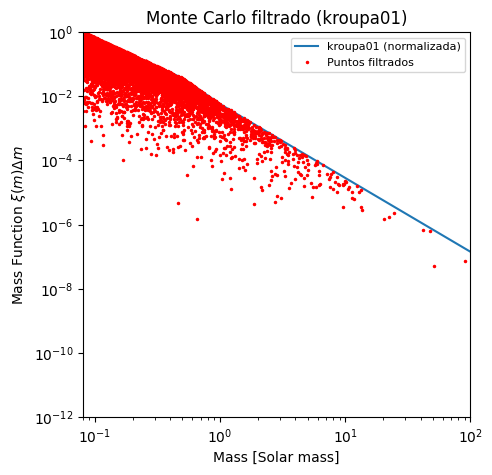


--- 3. Procesando evolución estelar ---
Tiempo de evolución: 0.0360 s

--- 4. Generando gráfico de SFR ---


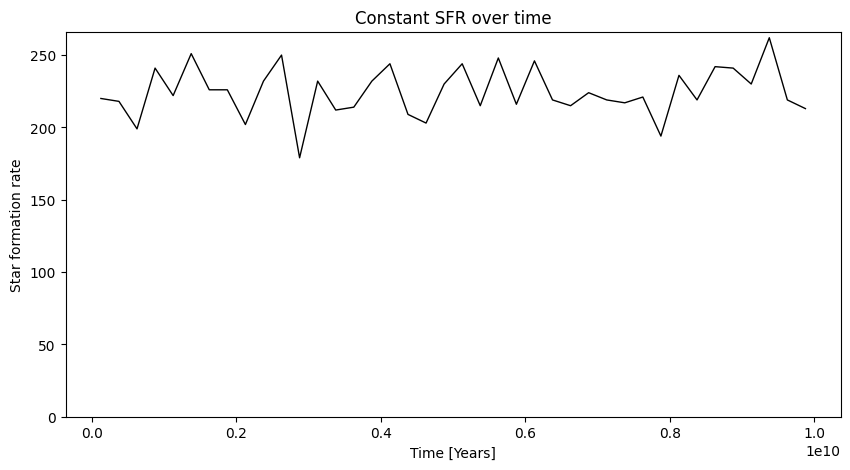


--- 5. Calculando masas finales de remanentes ---
Tiempo de cálculo de masas: 0.0288 s

--- 6. Generando gráfico de Relación de Masas ---


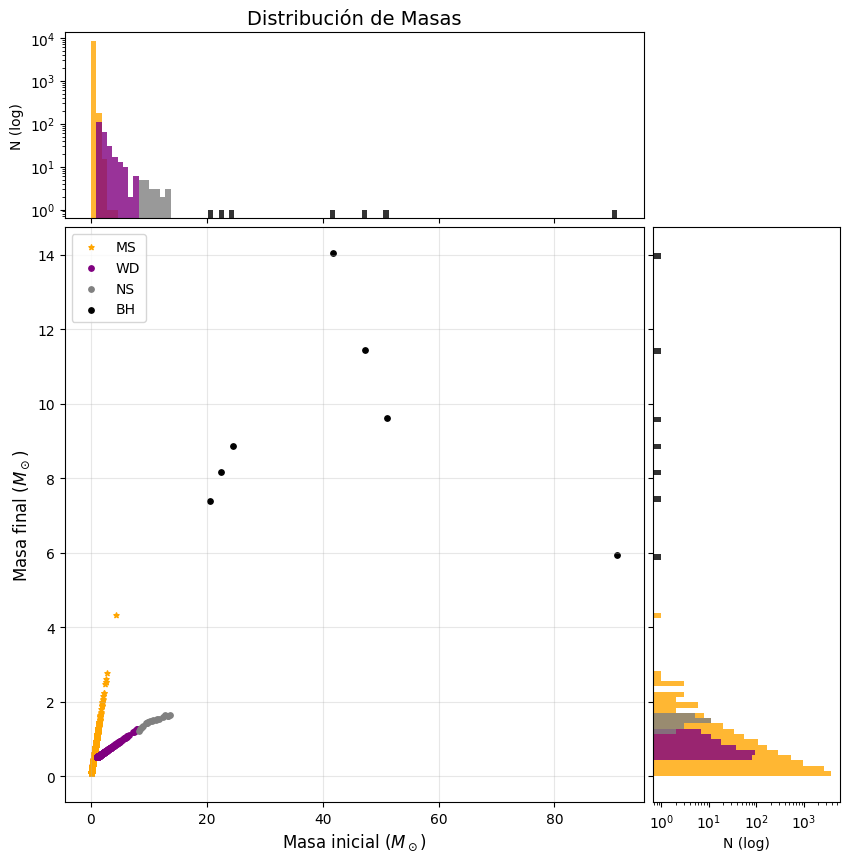


--- 7. Tabla de Resumen Estadístico ---


,Tipo,Fracción,Masa final más joven,Masa final más vieja
0,MS,0.968938,0.656634,0.487761
1,WD,0.027945,1.077925,0.670311
2,NS,0.002338,1.430474,1.211678
3,BH,0.000779,5.938166,8.177459



Simulación finalizada exitosamente.
Tiempo total de ejecución: 5.1654 segundos


In [12]:
print("Bienvenido a la simulación de montecarlo de síntesis de poblaciones estelares")

# ==========================================
# Celda Principal de Ejecución
# ==========================================

# ---------------------------------------------------------
# 1. Configuración Inicial y Parámetros
# ---------------------------------------------------------
# Solicitamos los inputs al usuario (interactivo)
iteraciones = obtener_numero_estrellas()
tiempo_simulacion = obtener_edad_maxima()

# Iniciamos el cronómetro global
global_start_time = time.perf_counter()

# ---------------------------------------------------------
# 2. Generación de Población (Monte Carlo)
# ---------------------------------------------------------
print("\n--- 1. Generando población estelar (Monte Carlo) ---")
t0 = time.perf_counter()

# Generamos los datos usando la IMF de Kroupa
# Retorna array Nx2: [masa, valor_random_y]
datos_iniciales = generar_datos_montecarlo(
    iteraciones=iteraciones,
    xmin=0.08,
    xmax=100.0,
    func_imf=kroupa01
)

print(f"Tiempo de generación: {time.perf_counter() - t0:.4f} s")

# ---------------------------------------------------------
# 3. Visualización de Control (IMF)
# ---------------------------------------------------------
print("\n--- 2. Generando gráfico de control (IMF) ---")
# Graficamos para verificar que la distribución sigue la curva teórica
graficar_montecarlo_imf(
    datos_iniciales,
    xmin=0.08,
    xmax=100.0,
    func_imf=kroupa01,
)

# ---------------------------------------------------------
# 4. Evolución Estelar (Edades y Etapas)
# ---------------------------------------------------------
print("\n--- 3. Procesando evolución estelar ---")
t0 = time.perf_counter()

# Asignamos edades y determinamos si son MS, WD, NS o BH
# Retorna array con columnas: [masa, edad, t_ms, sigue_ms, etapa]
resultado_etapas = procesar_evolucion_estelar(datos_iniciales, tiempo_simulacion)

print(f"Tiempo de evolución: {time.perf_counter() - t0:.4f} s")

# ---------------------------------------------------------
# 5. Visualización SFR (Tasa de Formación Estelar)
# ---------------------------------------------------------
print("\n--- 4. Generando gráfico de SFR ---")
graficar_sfr(resultado_etapas, tiempo_simulacion)

# ---------------------------------------------------------
# 6. Cálculo de Masas Finales (Remanentes)
# ---------------------------------------------------------
print("\n--- 5. Calculando masas finales de remanentes ---")
t0 = time.perf_counter()

# Aplicamos las fórmulas de pérdida de masa para obtener la masa final
# Retorna array completo con columna extra 'masa_final'
resultado_completo = calcular_masa_final(resultado_etapas)

print(f"Tiempo de cálculo de masas: {time.perf_counter() - t0:.4f} s")

# ---------------------------------------------------------
# 7. Visualización Final (Masa Inicial vs Final)
# ---------------------------------------------------------
print("\n--- 6. Generando gráfico de Relación de Masas ---")
# Genera el GridSpec con scatter central e histogramas marginales
graficar_relacion_masas(resultado_completo)

# ---------------------------------------------------------
# 8. Resumen Estadístico
# ---------------------------------------------------------
print("\n--- 7. Tabla de Resumen Estadístico ---")
tabla_final = generar_tabla_resumen(resultado_completo)

# Configuramos pandas para mostrar todas las columnas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
display(tabla_final) # 'display()' es la función nativa de Jupyter para mostrar DataFrames bonitos

# ---------------------------------------------------------
# Fin de la ejecución
# ---------------------------------------------------------
total_time = time.perf_counter() - global_start_time
print(f"\n========================================")
print(f"Simulación finalizada exitosamente.")
print(f"Tiempo total de ejecución: {total_time:.4f} segundos")
print(f"========================================")

# Help

In [13]:
import pandas as pd
import numpy as np

# ---------------------------------------------------------
# 1. Definición de la Metadata (DataFrame Completo)
# ---------------------------------------------------------

data_funciones = [
    # --- Funciones del Flujo Principal ---
    [
        "obtener_numero_estrellas",
        True,
        "Solicita al usuario el número de estrellas.",
        "default (int, opcional)",
        "iteraciones (int)"
    ],
    [
        "obtener_edad_maxima",
        True,
        "Solicita la edad máxima de la simulación en Gyr y la convierte a años. Gestiona errores de input.",
        "default_years (float, opcional)",
        "tiempo_years (float)"
    ],
    [
        "kroupa01",
        True,
        "Función matemática de la IMF de Kroupa (2001). Usada por defecto para el filtrado.",
        "m (float o np.array)",
        "valor_imf (float o np.array)"
    ],
    [
        "generar_datos_montecarlo",
        True,
        "Genera masas aleatorias y aplica Rejection Sampling usando una IMF.",
        "iteraciones (int), xmin (float, opcional), xmax (float,opcional), func_imf (func,opcional)",
        "datos (np.ndarray Nx2)"
    ],
    [
        "graficar_montecarlo_imf",
        True,
        "Genera un gráfico de control comparando la distribución generada vs la curva teórica.",
        "datos (np.ndarray), xmin (float, opcional), xmax (float, opcional), func_imf (func, opcional)",
        "None (Muestra plot)"
    ],
    [
        "procesar_evolucion_estelar",
        True,
        "Asigna edades aleatorias y clasifica en MS, WD, NS, BH según límites de masa.",
        "datos (np.ndarray), tiempo_simulacion (float)",
        "resultado_etapas (np.ndarray Nx5)"
    ],
    [
        "graficar_sfr",
        True,
        "Calcula y grafica la Tasa de Formación Estelar.",
        "resultado_etapas (np.ndarray), tiempo_simulacion (float)",
        "None (Muestra plot)"
    ],
    [
        "calcular_masa_final",
        True,
        "Calcula la masa del remanente aplicando fórmulas de pérdida de masa.",
        "resultado_etapas (np.ndarray)",
        "resultado_con_mf (np.ndarray Nx6)"
    ],
    [
        "graficar_relacion_masas",
        True,
        "Genera un gráfico de scatter, comparando masas iniciales y finales de las estrellas generadas, coloreado según el tipo de remanente. Genera histogramas de masa inicial y masa final con los mismos colores.",
        "resultado_con_mf (np.ndarray)",
        "None (Muestra plot)"
    ],
    [
        "generar_tabla_resumen",
        True,
        "Calcula estadísticas finales (fracciones por tipo y masas extremas).",
        "resultado_con_mf (np.ndarray)",
        "tabla (pd.DataFrame)"
    ],

    # --- Funciones Auxiliares / En Desuso / Alternativas ---
    [
        "iteraciones_necesarias_para_generar_N_estrellas",
        False,
        "Calcula cuántas iteraciones totales (intentos) se requieren, en promedio, para obtener N estrellas válidas mediante la IMF de Kroupa. Se apoya en las funciones kroupa_integral() y kroupa_ratio()",
        "num (int: estrellas deseadas), xmin (float, opcional), xmax (float, opcional)",
        "iteraciones (int)"
    ],
    [
        "kroupa_integral",
        False,
        "Calcula la integral analítica exacta de la función de Kroupa entre dos límites de masa. Usa sympy.",
        "xmin (float, opcional), xmax (float, opcional)",
        "integral (float)"
    ],
    [
        "kroupa_ratio",
        False,
        "Calcula la eficiencia del método Monte Carlo (ratio entre área bajo la curva y el rectángulo de generación).",
        "xmin (float, opcional), xmax (float,opcional)",
        "ratio (float)"
    ],
    [
        "salpeter55",
        False,
        "Función IMF alternativa: Salpeter (1955).",
        "m (float o np.array)",
        "valor (float o np.array)"
    ],
    [
        "millerscalo79",
        False,
        "Función IMF alternativa: Miller & Scalo (1979).",
        "m (float o np.array)",
        "valor (float o np.array)"
    ],
    [
        "chabrier03individual",
        False,
        "Función IMF alternativa: Chabrier (2003) para objetos individuales.",
        "m (float o np.array)",
        "valor (float o np.array)"
    ],
    [
        "chabrier03system",
        False,
        "Función IMF alternativa: Chabrier (2003) para sistemas estelares.",
        "m (float o np.array)",
        "valor (float o np.array)"
    ]
]

# Creamos el DataFrame
df_funciones = pd.DataFrame(
    data_funciones,
    columns=["Nombre", "En Main", "Descripción", "Inputs (Tipo)", "Output (Tipo)"]
)

# ---------------------------------------------------------
# 2. Función Auxiliar de Formato
# ---------------------------------------------------------
def _imprimir_fila_ayuda(row, index):
    # Función auxiliar para imprimir una sola fila
    estado = "IMPLEMENTADA EN MAIN" if row['En Main'] else "NO IMPLEMENTADA EN MAIN"

    print(f"\n[{index}] FUNCIÓN: {row['Nombre']}")
    print("=" * 70)
    print(f"Estado             : {estado}")
    print(f"Descripción        : {row['Descripción']}")
    print(f"Inputs             : {row['Inputs (Tipo)']}")
    print(f"Output             : {row['Output (Tipo)']}")
    print("-" * 70)

# ---------------------------------------------------------
# 3. Función Principal help() (Llamada ayuda)
# ---------------------------------------------------------
def ayuda():
    """
    Sistema interactivo de ayuda para la simulación estelar.
    Permite consultar funciones principales y auxiliares.
    """
    print("\n=== SISTEMA DE AYUDA DE LA SIMULACIÓN ===")
    print("Funciones disponibles en el notebook:\n")

    # Mostrar lista rápida
    print(f"{'IDX':<4} | {'NOMBRE':<50} | {'EN MAIN?':<10}")
    print("-" * 70)

    for i, row in df_funciones.iterrows():
        en_main = "SÍ" if row["En Main"] else "NO"
        print(f"{i:<4} | {row['Nombre']:<50} | {en_main:<10}")

    print("\nIngrese el número de la función para ver detalles.")
    seleccion = input("O ingrese '?' para ver TODO (cualquier otra tecla para salir): ")

    # CASO 1: Ver todo
    if seleccion == '?':
        for i, row in df_funciones.iterrows():
            _imprimir_fila_ayuda(row, i)
        return

    # CASO 2: Selección numérica
    if seleccion.isdigit():
        idx = int(seleccion)
        if 0 <= idx < len(df_funciones):
            row = df_funciones.iloc[idx]
            _imprimir_fila_ayuda(row, idx)
        else:
            print(f"\n[ADVERTENCIA] El índice {idx} no existe. Saliendo de la ayuda.")

    # CASO 3: Entrada inválida
    else:
        print("\n[ADVERTENCIA] Entrada no reconocida. Terminando función help.")


# =========================================================
# ayuda()

In [14]:
ayuda()


=== SISTEMA DE AYUDA DE LA SIMULACIÓN ===
Funciones disponibles en el notebook:

IDX  | NOMBRE                                             | EN MAIN?  
----------------------------------------------------------------------
0    | obtener_numero_estrellas                           | SÍ        
1    | obtener_edad_maxima                                | SÍ        
2    | kroupa01                                           | SÍ        
3    | generar_datos_montecarlo                           | SÍ        
4    | graficar_montecarlo_imf                            | SÍ        
5    | procesar_evolucion_estelar                         | SÍ        
6    | graficar_sfr                                       | SÍ        
7    | calcular_masa_final                                | SÍ        
8    | graficar_relacion_masas                            | SÍ        
9    | generar_tabla_resumen                              | SÍ        
10   | iteraciones_necesarias_para_generar_N_estrellas    | NO    